# License 
***
Copyright 2017 J. Patrick Hall, phall@h2o.ai & Navdeep Gill, navdeep@h2o.ai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Decision Tree Surrogates (Global Surrogates)
***
Based on: Craven, Mark W. and Shavlik, Jude W. Extracting tree structured representations of trained networks. Advances in Neural Information Processing Systems, pp. 24–30, 1996.

https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf

** Requires GraphViz **

GraphViz: http://www.graphviz.org/

For MacOS: 
* Install Brew: https://brew.sh/ 
* `brew install graphviz`

## Preliminaries: imports, start H2O, load data

In [1]:
# imports

# import h2o module and certain needed classes
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.backend import H2OLocalServer

# for in-notebook display 
from IPython.display import Image
from IPython.display import display

# for calling external processes
import os
import re
import subprocess
from subprocess import CalledProcessError
import time

In [2]:
# start and connect to h2o server
h2o.init(max_mem_size='12G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpo17o6sd8
  JVM stdout: /tmp/tmpo17o6sd8/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpo17o6sd8/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_patrickh_buru4a
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [3]:
# load clean data
path = '../data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Clean and prepare data for modeling

In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')
_ = frame[enums].impute(method='mode')

In [6]:
# split into training, validation, and 30% test
train, valid = frame.split_frame([0.7])

## Train a "black box" model 

In [7]:
# initialize pre-tuned nn model
nn_model = H2ODeepLearningEstimator(
    epochs=50,                    # read over the data 50 times, but in mini-batches
    hidden=[100],                 # 100 hidden units in 1 hidden layer
    activation='Tanh',            # bounded activation function that allows for dropout, tanh  
    l2=0.007,                     # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate=True,           # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds=2,            # stop after validation error does not decrease for 5 iterations
    score_each_iteration=True,    # score validation error on every iteration
    reproducible=True,
    seed=12345)                   
    
# train nn model
nn_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [8]:
# measure nn AUC
print(nn_model.rmsle(train=True))
print(nn_model.rmsle(valid=True))

0.1055395942558104
0.17196763577524285


## Use a decision tree surrogate to generate explanations of the "black box" model

#### First bind the "black box" model predictions onto the training frame

In [9]:
# cbind predictions to training frame
# give them a nice name
preds = nn_model.predict(frame)
preds.columns = ['predicted_SalePrice']
frame_yhat = frame.cbind(preds)

deeplearning prediction progress: |███████████████████████████████████████| 100%


#### Train decision tree surrogate model

In [10]:
yhat = 'predicted_SalePrice'
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=X, y=yhat, training_frame=frame_yhat)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5088845423.26723
RMSE: 71336.14387719054
MAE: 53990.482603809935
RMSLE: 0.37110304191861543
Mean Residual Deviance: 5088845423.26723
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2018-09-21 14:42:38,0.005 sec,0.0,77247.1503077,58648.1442489,5967122230.6633215
,2018-09-21 14:42:39,0.117 sec,1.0,71336.1438772,53990.4826038,5088845423.2672300


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OverallQual,6443843977216.0000000,1.0,0.9548046
GrLivArea,305017716736.0000000,0.0473347,0.0451954
MSSubClass,0.0,0.0,0.0
MSZoning,0.0,0.0,0.0
LotFrontage,0.0,0.0,0.0
---,---,---,---
MiscVal,0.0,0.0,0.0
MoSold,0.0,0.0,0.0
YrSold,0.0,0.0,0.0
SaleType,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 /home/patrickh/workspace/mli-resources/notebooks/dt_surrogate_mojo.zip


#### Generate GraphViz representation of MOJO

In [11]:
details = False # print more info on tree, details = True
title = 'Home Prices Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/mli-resources/notebooks/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Home Prices Decision Tree Surrogate


#### Generate PNG from GraphViz representation

In [12]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


#### Display decision tree surrogate

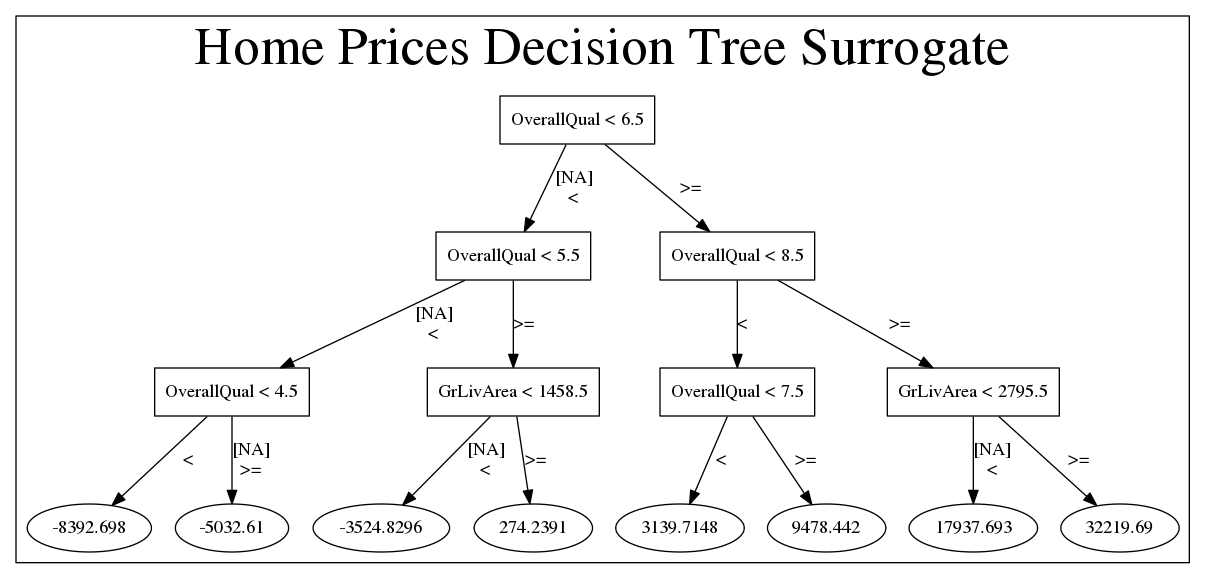

In [13]:
display(Image((png_file_name)))

#### From this surrogate model we can see ...
* Some of the most important variables
* Important interactions 
* The decision path for the most expensive houses
* The decision path for the least expensive houses


In [14]:
# shutdown h2o
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_ba62 closed.
